<a href="https://colab.research.google.com/github/Tichow/TP_IA_embarquee/blob/main/neural_network/TP_IA_EMBARQUEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import to_categorical


**QUESTION:** Load dataset and display some lines of the csv file.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/data/ai4i2020.csv'
df = pd.read_csv(file_path)
print(df.head())

Mounted at /content/drive
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

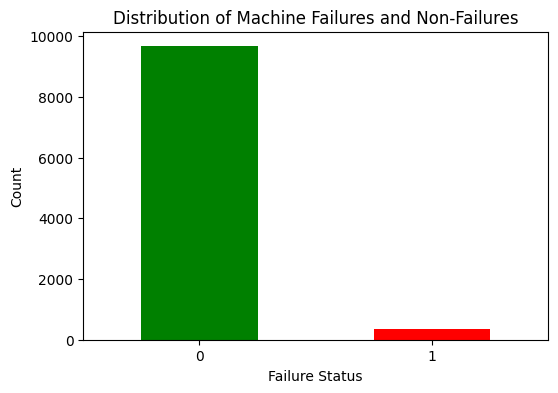

In [3]:
failure_counts = df['Machine failure'].value_counts()

plt.figure(figsize=(6,4))
failure_counts.plot(kind='bar', color=['green', 'red'])
plt.xlabel('Failure Status')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.xticks(rotation=0)
plt.show()

**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

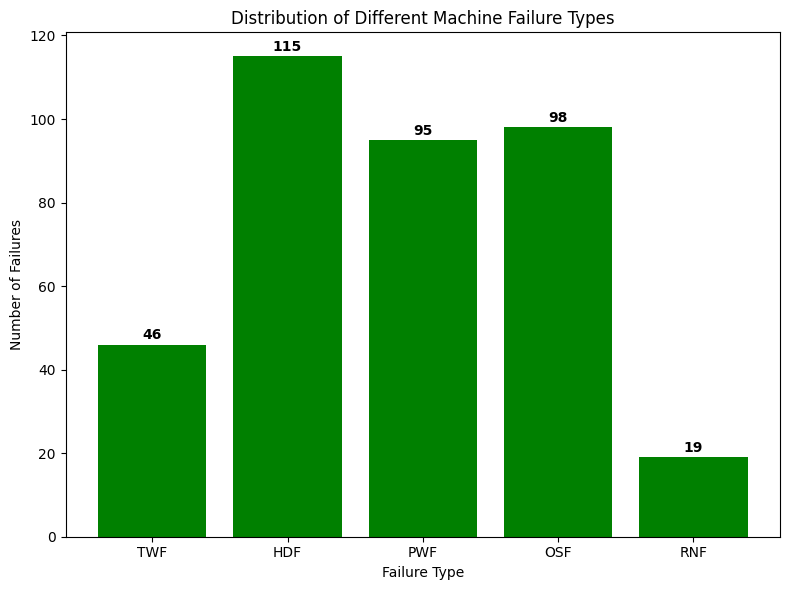

In [4]:
failure_counts = {
    'TWF': df['TWF'].sum(),
    'HDF': df['HDF'].sum(),
    'PWF': df['PWF'].sum(),
    'OSF': df['OSF'].sum(),
    'RNF': df['RNF'].sum()
}

plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.keys(), failure_counts.values(), color='green')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.5,
             f'{int(bar.get_height())}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Failure Type')
plt.ylabel('Number of Failures')
plt.title('Distribution of Different Machine Failure Types')
plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** What do you observe?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

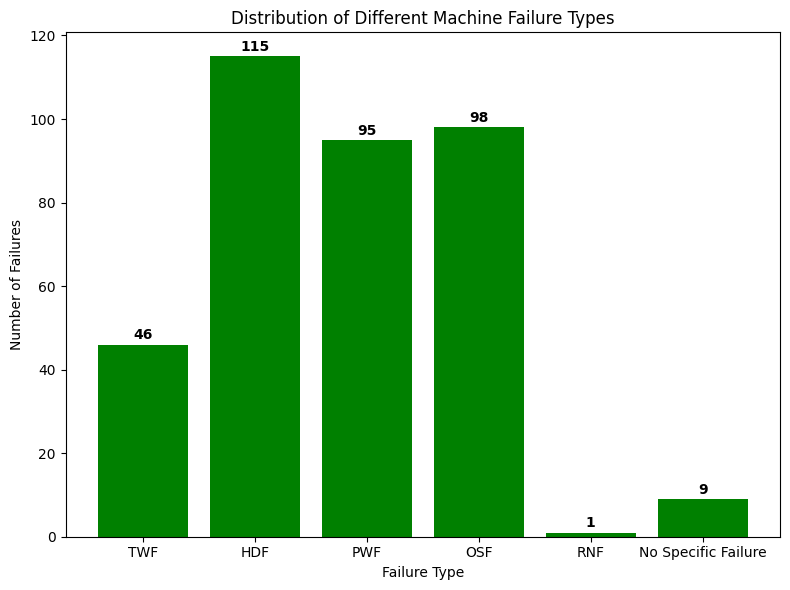

In [5]:
failure_data = df[df['Machine failure'] == 1]
no_specific_failure_data = df[
    (df['Machine failure'] == 1) &
    (df['TWF'] == 0) &
    (df['HDF'] == 0) &
    (df['PWF'] == 0) &
    (df['OSF'] == 0) &
    (df['RNF'] == 0)
]

failure_counts = {
    'TWF': failure_data['TWF'].sum(),
    'HDF': failure_data['HDF'].sum(),
    'PWF': failure_data['PWF'].sum(),
    'OSF': failure_data['OSF'].sum(),
    'RNF': failure_data['RNF'].sum(),
    'No Specific Failure': len(no_specific_failure_data)
}



plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.keys(), failure_counts.values(), color='green')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.5,
             f'{int(bar.get_height())}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Failure Type')
plt.ylabel('Number of Failures')
plt.title('Distribution of Different Machine Failure Types')
plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

"Write your response here"

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [6]:
print(df.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Inputs : UDI, Product ID, Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Tool wear [min]  
Outputs : Machine failure, TWF, HDF, PWF, OSF, RNF           

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [7]:
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

#print("X_train : ", X_train),
#print("X_test : ", X_test),
#print("Y_train : ", Y_train),
print("Y_test : ", Y_test)

print("X_train : ", X_train.shape),
print("X_test : ", X_test.shape),
print("Y_train : ", Y_train.shape),
print("Y_test : ", Y_test.shape)


Y_test :        Machine failure  TWF  HDF  PWF  OSF  RNF
4343                0    0    0    0    0    0
1794                0    0    0    0    0    0
708                 0    0    0    0    0    0
3383                0    0    0    0    0    0
4534                0    0    0    0    0    0
...               ...  ...  ...  ...  ...  ...
9920                0    0    0    0    0    0
6123                0    0    0    0    0    0
7516                0    0    0    0    0    0
6746                0    0    0    0    0    0
2908                0    0    0    0    0    0

[1000 rows x 6 columns]
X_train :  (8000, 5)
X_test :  (1000, 5)
Y_train :  (8000, 6)
Y_test :  (1000, 6)


**QUESTION** Code below the model architecture

In [8]:
# (1) DEFINE THE ARCHITECTURE OF MY MODEL
#first, I define all the layers and the way they are connected
inputs = tf.keras.Input(shape=(5,))
x = tf.keras.layers.Flatten()(inputs) #cf. question below...
x = tf.keras.layers.Dense(20, activation='tanh')(x) #a first hidden layer with 20 neurons
outputs = tf.keras.layers.Dense(6, activation='relu')(x) # my output layer
#Then, I define my model with the input layer, the output layer and a name
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")


my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

if X_train.ndim == 1:
  X_train = to_categorical(X_train, num_classes=4)
  X_val = to_categorical(X_val, num_classes=4)
  X_test = to_categorical(X_test, num_classes=4)

if Y_train.ndim == 1:
  Y_train = to_categorical(Y_train, num_classes=4)
  Y_val = to_categorical(Y_val, num_classes=4)
  Y_test = to_categorical(Y_test, num_classes=4)

# (3) NOW, LET'S TRAIN ON MY DATA WITH THE "FIT" METHOD

nb_epochs=4
batch_size=100
training_history = my_mlp_model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(X_val,Y_val))

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS

loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)


my_mlp_model.summary()

Epoch 1/4
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1751 - loss: 0.2530 - val_accuracy: 0.9970 - val_loss: 0.2855
Epoch 2/4
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.2273 - val_accuracy: 0.9970 - val_loss: 0.3210
Epoch 3/4
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.2194 - val_accuracy: 0.9970 - val_loss: 0.3208
Epoch 4/4
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.2548 - val_accuracy: 0.9970 - val_loss: 0.3201
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.2237
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9962 - loss: 0.2638 
Performance on the TRAIN set, ACCURACY= 0.9984999895095825
Performance on the TEST set, ACCURACY= 0.996999979019165


Model: "my_mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 740 (2.89 KB)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 494 (1.93 KB)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"